# Monte Carlo with Adiabatic Optimization Method

This code uses the new optimization method which incrementall adjusts the solution landscape.

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import numpy as np
from matplotlib import pyplot as plt

import time

from lib.qvmc.hamiltonian import Hamiltonian
from lib.qvmc.state import State
from lib.qvmc.optimizer import Optimizer
from lib.qvmc.debug import Plotter

## The Hamiltonian 

We'll use the adiabatic Hamiltonian
![alt text](images/adiabatic_hamiltonian3.png "Adiabatic Hamiltonian")

## The State

We'll use the RBM Wave Function with Two Biases. Total of 2N + 1 variational Parameters

![alt text](images/RBMWaveFunc.png "Adiabatic Hamiltonian")

variational parameters will be organized like this:

self.parameter = {"a" : N length 1-d np array of parameters,
                   "b" : N length 1-d np array of parameter,
                   "w" : NxN 2d np array of paramters}

In [5]:
num_particles = 4
num_parameters = 5
num_steps = 1000
var = 3.14159j / 4
delta = 1

initial_parameters = {"a" : np.asarray([0, 0, 0, 0]),
                      "b" : np.asarray([0,0,0,0]) ,
                      "w" : np.asarray([[var, var, 0 , 0],
                                       [0, 0, 0 , 0],
                                       [0, 0, var, var],
                                       [0, 0, 0, 0]])}
fixed_params = None
deltas = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
running_deltas = []
energies = []
for delta in deltas:
    plotter = Plotter(delta)
    H = Hamiltonian(num_particles, delta=delta)
    opt = Optimizer(H, num_steps, plotter=plotter, num_parameters=5, 
                    parameters = initial_parameters, lr = 0.3, random_noise=True)
    energy, initial_parameters = opt.get_ground_state()
    energies.append(energy)
    running_deltas.append(delta)
    plt.plot(running_deltas, energies)
    plt.title("Energy(delta)")
    plt.xlabel("Delta")
    plt.ylabel("Variational Energy")
    plt.show()
    time.sleep(4)

TypeError: __init__() got an unexpected keyword argument 'random_noise'

## With Fixed Parameters

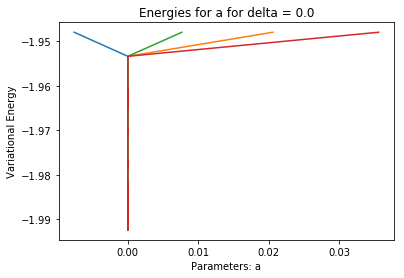

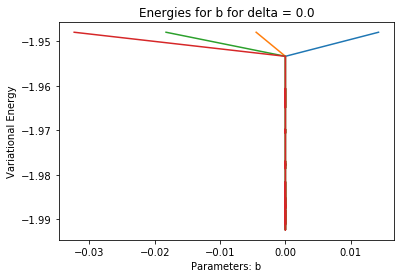

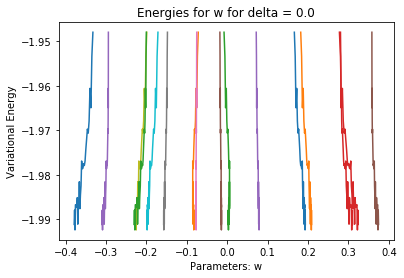

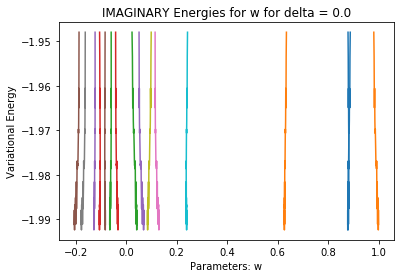

Ending because loop count == 20
Time caught in local min: 29
Reset Count: 0
Loop Count 30
Optimal Energy: -1.99
Optimal Alpha: {'a': array([0, 0, 0, 0]), 'b': array([0, 0, 0, 0]), 'w': array([[-0.3799147 +0.87770115j, -0.08165042+0.62645521j,
         0.00193185+0.04211947j,  0.3254534 -0.10716218j],
       [ 0.07925175+0.0705218j , -0.01443936-0.20769349j,
        -0.07682744+0.13102435j, -0.15759606-0.1801188j ],
       [-0.22605833+0.0833022j , -0.19927031+0.23945135j,
         0.1937697 +0.87832231j,  0.20917201+1.0004731j ],
       [-0.23174174-0.06644513j,  0.31131438-0.0322729j ,
        -0.3107425 -0.12914903j,  0.37534509-0.08312855j]])}


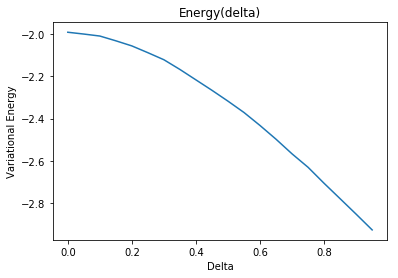

In [6]:
num_particles = 4
num_parameters = 5
num_steps = 5000
var = 3.14159j / 4
delta = 1

initial_parameters = {"a" : np.asarray([0, 0, 0, 0]),
                      "b" : np.asarray([0,0,0,0]) ,
                      "w" : np.asarray([[var, var, 0 , 0],
                                       [0, 0, 0 , 0],
                                       [0, 0, var, var],
                                       [0, 0, 0, 0]])}
fixed_params =  {"a" : np.asarray([0, 0, 0, 0]),
                 "b" : np.asarray([0,0,0,0]) }
# fixed_params = None

deltas = [0.95-(x/20) for x in range(20)]
running_deltas = []
energies = []
for delta in deltas:
    plotter = Plotter(delta)
    H = Hamiltonian(num_particles, delta=delta)
    if delta = deltas[0]: # add random noise
        opt = Optimizer(H, num_steps, plotter=plotter, num_parameters=5, 
                    parameters = initial_parameters, lr = 0.02, random_noise_scale=0.02,
                   fixed_parameters = fixed_params)
    else: # no random noise
        opt = Optimizer(H, num_steps, plotter=plotter, num_parameters=5, 
                        parameters = initial_parameters, lr = 0.02, fixed_parameters = fixed_params)
    energy, initial_parameters = opt.get_ground_state()
    energies.append(energy)
    running_deltas.append(delta)
    plt.plot(running_deltas, energies)
    plt.title("Energy(delta)")
    plt.xlabel("Delta")
    plt.ylabel("Variational Energy")
    plt.show()
    time.sleep(4)

In [ ]:
X = X[0:3,0:3]; X